# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.03030733, -0.23434482, -0.04628686,  0.23896809]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.4018719886925046 -2.556581882025758


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # returning the given data to the model
    return actions, states

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, # model input
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    # last_action = tf.zeros([1, action_size])
    # actions_labels = tf.concat(axis=0, values=[actions_onehot[1:], last_action])
    # loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
    #                                                                  labels=actions_labels))
    # # # #if actions.shape[0] < 200: 
    # def loss_false(): 
    #     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
    #                                                                      labels=actions_labels))
    # # # #if actions.shape[0] = 200: 
    # def loss_true(): 
    #     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
    #                                                                      labels=actions_onehot[1:]))
    # loss = tf.cond(pred=tf.equal(total_rewards, 200), 
    #                true_fn=loss_true, 
    #                false_fn=loss_false)
        
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [24]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [25]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [26]:
env.reset()

array([ 0.00933892,  0.02862678, -0.00222753, -0.03048953])

In [27]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
state, reward, action

(array([-0.08450606, -1.59501906,  0.22873811,  2.58663364]), 0.0, 0.0)

In [37]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            action *= reward
            batch.append([action, state])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states})
            
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss),
              'Episode done: {}'.format(done))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 10 Batch loss: 0.541349113 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 9 Batch loss: 0.518096805 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 11 Batch loss: 0.459903866 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 10 Batch loss: 0.432396829 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 41 Total reward: 9 Batch loss: 0.025138373 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 42 Total reward: 8 Batch loss: 0.029006556 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 43 Total reward: 10 Batch loss: 0.022429846 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 10 Batch loss: 0.020529570 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 85 Total reward: 10 Batch loss: 0.003981519 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 86 Total reward: 11 Batch loss: 0.003062376 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 87 Total reward: 9 Batch loss: 0.003250810 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 88 Total reward: 9 Batch loss: 0.003936687 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 134 Total reward: 9 Batch loss: 0.001319216 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 9 Batch loss: 0.001552016 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 10 Batch loss: 0.001058008 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 137 Total reward: 10 Batch loss: 0.001525549 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 177 Total reward: 10 Batch loss: 0.000685462 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 9 Batch loss: 0.000561389 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 9 Batch loss: 0.000765943 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 180 Total reward: 10 Batch loss: 0.000670674 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 225 Total reward: 9 Batch loss: 0.000377373 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 226 Total reward: 10 Batch loss: 0.000361131 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 227 Total reward: 10 Batch loss: 0.000369947 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 8 Batch loss: 0.000338108 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 269 Total reward: 9 Batch loss: 0.000241570 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 270 Total reward: 9 Batch loss: 0.000266633 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 271 Total reward: 10 Batch loss: 0.000233741 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 8 Batch loss: 0.000240745 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 316 Total reward: 10 Batch loss: 0.000147045 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 9 Batch loss: 0.000164606 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 318 Total reward: 8 Batch loss: 0.000167461 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 319 Total reward: 9 Batch loss: 0.000164977 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 360 Total reward: 10 Batch loss: 0.000146130 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 9 Batch loss: 0.000097548 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 8 Batch loss: 0.000115467 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 10 Batch loss: 0.000130539 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 402 Total reward: 9 Batch loss: 0.000069963 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 10 Batch loss: 0.000075788 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 404 Total reward: 8 Batch loss: 0.000103313 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 405 Total reward: 9 Batch loss: 0.000070112 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 446 Total reward: 9 Batch loss: 0.000098814 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 447 Total reward: 9 Batch loss: 0.000063975 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 448 Total reward: 8 Batch loss: 0.000049109 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 9 Batch loss: 0.000054933 Episode done: True
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 490 Total reward: 9 Batch loss: 0.000057182 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 491 Total reward: 10 Batch loss: 0.000042168 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 492 Total reward: 9 Batch loss: 0.000049018 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 10 Batch loss: 0.000050445 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 538 Total reward: 9 Batch loss: 0.000033510 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 9 Batch loss: 0.000043670 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 8 Batch loss: 0.000049875 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 10 Batch loss: 0.000029813 Episode done: True
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 581 Total reward: 9 Batch loss: 0.000029040 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 582 Total reward: 9 Batch loss: 0.000036787 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 10 Batch loss: 0.000033256 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 10 Batch loss: 0.000038010 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 624 Total reward: 9 Batch loss: 0.000033510 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 8 Batch loss: 0.000026974 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 8 Batch loss: 0.000029868 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 9 Batch loss: 0.000031588 Episode done: True
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 666 Total reward: 9 Batch loss: 0.000023855 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 10 Batch loss: 0.000030647 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 8 Batch loss: 0.000025543 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 10 Batch loss: 0.000025986 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 709 Total reward: 10 Batch loss: 0.000019960 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 710 Total reward: 8 Batch loss: 0.000021712 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 711 Total reward: 10 Batch loss: 0.000021085 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 712 Total reward: 10 Batch loss: 0.000023589 Episode done: True
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 755 Total reward: 11 Batch loss: 0.000018619 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 756 Total reward: 9 Batch loss: 0.000017031 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 757 Total reward: 8 Batch loss: 0.000017046 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 758 Total reward: 10 Batch loss: 0.000024833 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 801 Total reward: 8 Batch loss: 0.000015803 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 802 Total reward: 11 Batch loss: 0.000013148 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 803 Total reward: 10 Batch loss: 0.000012477 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 804 Total reward: 10 Batch loss: 0.000016980 Episode done: True
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 845 Total reward: 10 Batch loss: 0.000018172 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 846 Total reward: 10 Batch loss: 0.000012649 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 847 Total reward: 10 Batch loss: 0.000011656 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 8 Batch loss: 0.000013096 Episode done: True
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 889 Total reward: 11 Batch loss: 0.000012886 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 9 Batch loss: 0.000011682 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 891 Total reward: 10 Batch loss: 0.000012371 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 892 Total reward: 9 Batch loss: 0.000012591 Episode done: True
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 934 Total reward: 10 Batch loss: 0.000012861 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 10 Batch loss: 0.000011629 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 10 Batch loss: 0.000013179 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 10 Batch loss: 0.000008649 Episode done: True
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 980 Total reward: 9 Batch loss: 0.000009849 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 981 Total reward: 9 Batch loss: 0.000013306 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 982 Total reward: 8 Batch loss: 0.000010746 Episode done: True
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 983 Total reward: 9 Batch loss: 0.000009685 Episode done: True
-------------------------------------------------------------------------------
------------------------------------------------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

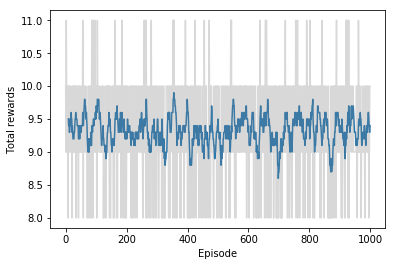

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

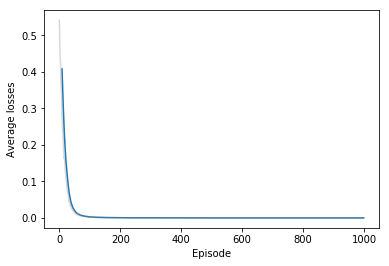

In [40]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [42]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for each_episode in range(1):

        # Start a new episode/epoch
        state = env.reset()
        
        # Rendering the env graphics
        env.render()

        # Steps/batches
        for each_step in range(111111111111111111):
                        
            # Calculating next action using OLD memory
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            #reward = 1 - float(done)
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.